# Build some toy models and how to sample them

## Roadmap

- Visualize the sampling process
- Write the simplest possible sampling (random choice of innermost or outmost 4 hits)
- Evaluate the circle fit error between innermost and outermost fits

In [1]:
# use autoreload
%load_ext autoreload
%autoreload 2

import yaml
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# imports
from jepa.modules import JEPA

## Explore Model Loading

In [2]:
with open("configs/1_testing.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
model = JEPA(**config)

In [4]:
model

JEPA(
  (encoder): JEPAEncoder(
    (encoder): Transformer(
      (input_encoder): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): Dropout(p=0.0, inplace=False)
        (2): SiLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
      (encoder_layers): ModuleList(
        (0-11): 12 x AttentionBlock(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (feed_forward): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): SiLU()
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=256, out_features=128, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (norm_self_attn): SetNorm()
          (norm_ff): SetNorm()
          (activation): SiLU()
        )
      )
    )
    (aggregator): Aggregator()
  )
  (

In [5]:
for batch in model.train_dataloader():
    print(batch)
    break

(tensor([[[-0.8417, -0.1618],
         [-2.2656,  0.3029],
         [-0.4790, -0.1434],
         [-2.8650,  0.8899],
         [-1.2075, -0.1283],
         [-1.9259,  0.1019],
         [-1.5709, -0.0411],
         [-2.5819,  0.5645]]]), tensor([[True, True, True, True, True, True, True, True]]), [Event(particles=         vx        vy   vz        pt     pphi  dimension  charge  particle_id  \
0  0.116666  0.003119  0.0  2.570586  1.93154          2      -1            0   

        d0       phi  
0  0.02134 -1.514617  , hits=          x         y  particle_id
0 -0.841727 -0.161831            0
1 -2.265560  0.302869            0
2 -0.479003 -0.143374            0
3 -2.864960  0.889945            0
4 -1.207487 -0.128320            0
5 -1.925877  0.101904            0
6 -1.570892 -0.041072            0
7 -2.581873  0.564471            0), tracks=[[2 0 4 6 5 1 7]
 [0 4 6 5 1 7 3]], detector=Detector(dimension=2), layers: [{'shape': 'cylinder', 'radius': 0.5, 'length': None}, {'shape': 'cylind

In [6]:
for batch in model.train_dataloader():
    x, mask, events_df = batch
    print(x.shape, mask.shape)

    context_mask, target_mask, inner_target_flag = model.sample_context(x, mask)
    print(context_mask.shape, target_mask.shape)

    break


torch.Size([1, 8, 2]) torch.Size([1, 8])
batch_randoms: tensor([0.7280])
target_mask: tensor([[ True, False,  True, False,  True, False,  True, False]])
target_mask: tensor([[ True, False,  True, False,  True, False,  True, False]])
torch.Size([1, 8]) torch.Size([1, 8])


In [7]:
context_mask

tensor([[False,  True, False,  True, False,  True, False,  True]])

In [8]:
target_mask

tensor([[ True, False,  True, False,  True, False,  True, False]])

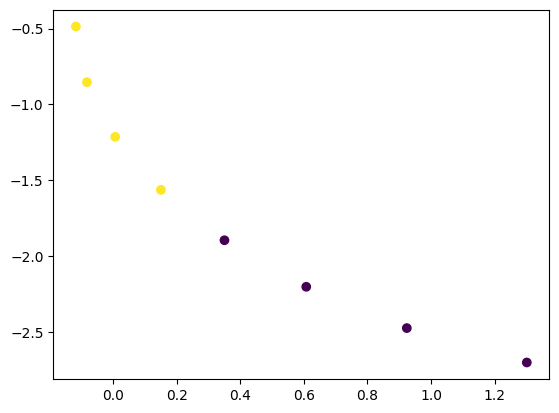

In [9]:
# Plot the x positions, along with whether they are in the context or target mask
plt.scatter(x[..., 0], x[..., 1], c=target_mask)
plt.show()

## Circle Fit

In [10]:
from jepa.utils import fit_circle

In [26]:
events_df[0].particles

,vx,vy,vz,pt,pphi,dimension,charge,particle_id,d0,phi
0,-0.061887,0.097581,0.0,2.527607,2.930841,2,1,0,0.070303,-3.096031


In [30]:
target_params = fit_circle(x[target_mask][:, 0], x[target_mask][:, 1])
source_params = fit_circle(x[context_mask][:, 0], x[context_mask][:, 1])

In [28]:
x[context_mask][0]

tensor([ 0.6076, -2.2035])

In [32]:
target_params, source_params

((2.409793391682388, -0.4311825658999078, 2.5276068836224663),
 (2.409790776381923, -0.43118557485410286, 2.5276030095543787))

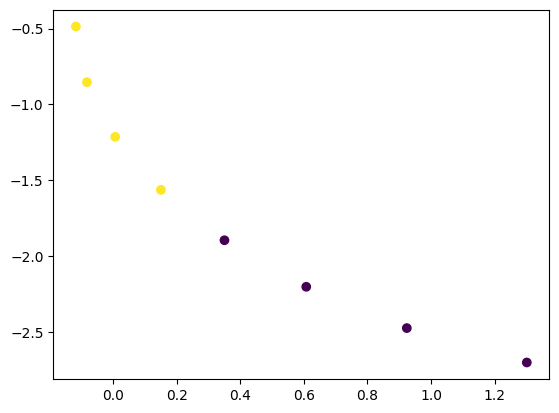

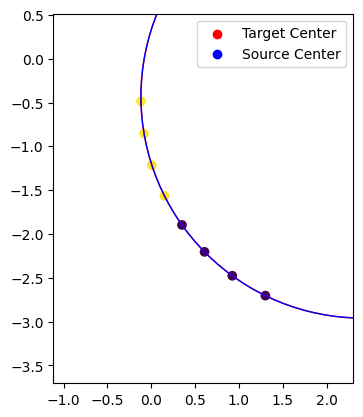

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Convert tensors to numpy arrays
x_np = x.numpy()
target_mask_np = target_mask.numpy()
context_mask_np = context_mask.numpy()

# First plot the x positions, with their mask color
plt.scatter(x_np[..., 0], x_np[..., 1], c=target_mask_np)
plt.show()

# Plot the circles given by target_params and source_params (center x, center y and radius)
fig, ax = plt.subplots()
ax.scatter(x_np[..., 0], x_np[..., 1], c=target_mask_np)

# Plot the center points
ax.scatter(target_params[0], target_params[1], color='r', label='Target Center')
ax.scatter(source_params[0], source_params[1], color='b', label='Source Center')

# Add the target circle
target_circle = plt.Circle((target_params[0], target_params[1]), target_params[2], color='r', fill=False)
ax.add_artist(target_circle)

# Add the source circle
source_circle = plt.Circle((source_params[0], source_params[1]), source_params[2], color='b', fill=False)
ax.add_artist(source_circle)

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Set the limits of the plot to ensure the circles are fully visible
ax.set_xlim(np.min(x_np[..., 0]) - 1, np.max(x_np[..., 0]) + 1)
ax.set_ylim(np.min(x_np[..., 1]) - 1, np.max(x_np[..., 1]) + 1)

# Add a legend
ax.legend()

plt.show()

In [38]:
error = np.mean(np.array(source_params) - np.array(target_params))

In [39]:
error

-3.1661075826083795e-06